# Setup, imports


In [24]:
# Add the parent directory to path
import sys
sys.path.append('..')

In [25]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env import Env, Log
from epidemic_env.dynamics import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


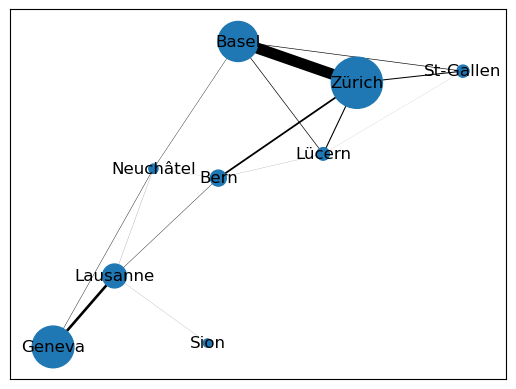

In [26]:
dyn = ModelDynamics('../config/switzerland.yaml')  # load the switzerland map
print(dyn.cities)
dyn.draw_map()

# Question 2.a

In [27]:
"""Loading the environment"""
env = Env(dyn,  # We pass the dynamical model to the environment
          action_space=None,  # Here one could pass an openai gym action space that can then be sampled
          observation_space=None,  # Here one could pass an openai gym obs space that can then be sampled
          )

In [28]:
action = { # DO NOTHING
    'confinement': False,
    'isolation': False,
    'hospital': False,
    'vaccinate': False,
}

In [29]:
# Set Russo strategy constants
CONFINEMENT_WEEKS = 4
INFECTED_THRESHOLD = 20000

In [30]:
def exec_russo_policy(environment, n_weeks=30, simulation_seed=0):
    log = []
    # finished = False
    curr_rewards = []

    # print(f"Sim seed = {simulation_seed}")
    _, _ = environment.reset(simulation_seed)

    curr_policy  = []
    curr_conf_week = 0

    policy_action = { # DO NOTHING
        'confinement': False,
        'isolation': False,
        'hospital': False,
        'vaccinate': False,
    }

    for t in range(n_weeks):
        obs, rew, finished, info = env.step(policy_action)
        if obs.total.infected[-1] > INFECTED_THRESHOLD and curr_conf_week == 0:
            policy_action['confinement'] = True
            curr_conf_week = 1
        elif 0 < curr_conf_week < CONFINEMENT_WEEKS:
            curr_conf_week += 1
        elif curr_conf_week == CONFINEMENT_WEEKS:
            policy_action['confinement'] = False
            curr_conf_week = 0
        log.append(info) # save the information dict for logging

        curr_policy.append(int(policy_action['confinement']))
        curr_rewards.append(rew)
        if finished:
            break
    """ Parse the logs """
    tot = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cit = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    act = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    # print(len(curr_policy))
    return tot, cit, act, curr_policy, curr_rewards

Text(0.5, 0, 'Weeks')

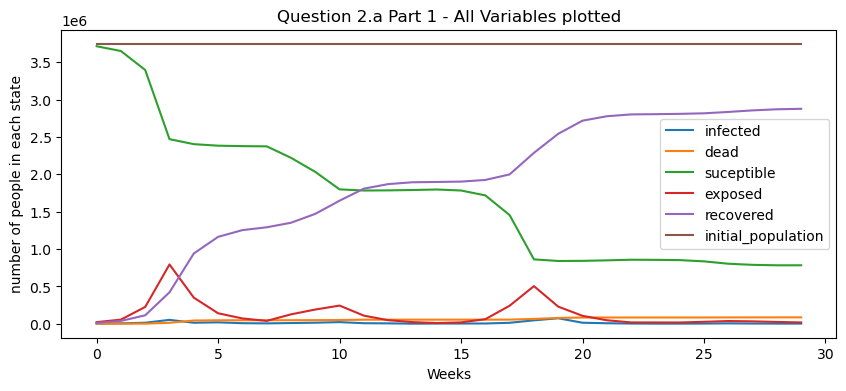

In [31]:
seed = 0

fig, ax = plt.subplots(1,1,figsize=(10,4))

""" Run the simulations, seeded"""

total, cities, actions, policy, _ = exec_russo_policy(env, n_weeks=30, simulation_seed=seed)


[ax.plot(y) for y in total.values()]
ax.legend(total.keys())
ax.set_title("Question 2.a Part 1 - All Variables plotted")
ax.set_ylabel('number of people in each state')
ax.set_xlabel('Weeks')

Text(0.5, 0, 'Weeks')

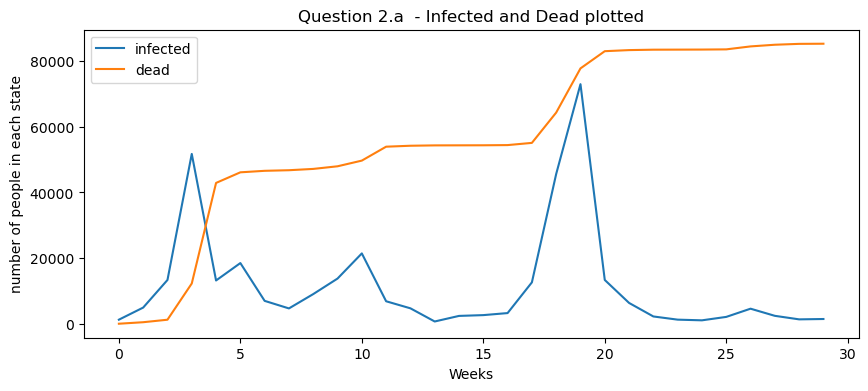

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

total_tmp = {'infected': total['infected'], 'dead': total['dead']}
[ax.plot(y) for y in total_tmp.values()]
ax.legend(total_tmp.keys())
ax.set_title("Question 2.a  - Infected and Dead plotted")
ax.set_ylabel('number of people in each state')
ax.set_xlabel('Weeks')

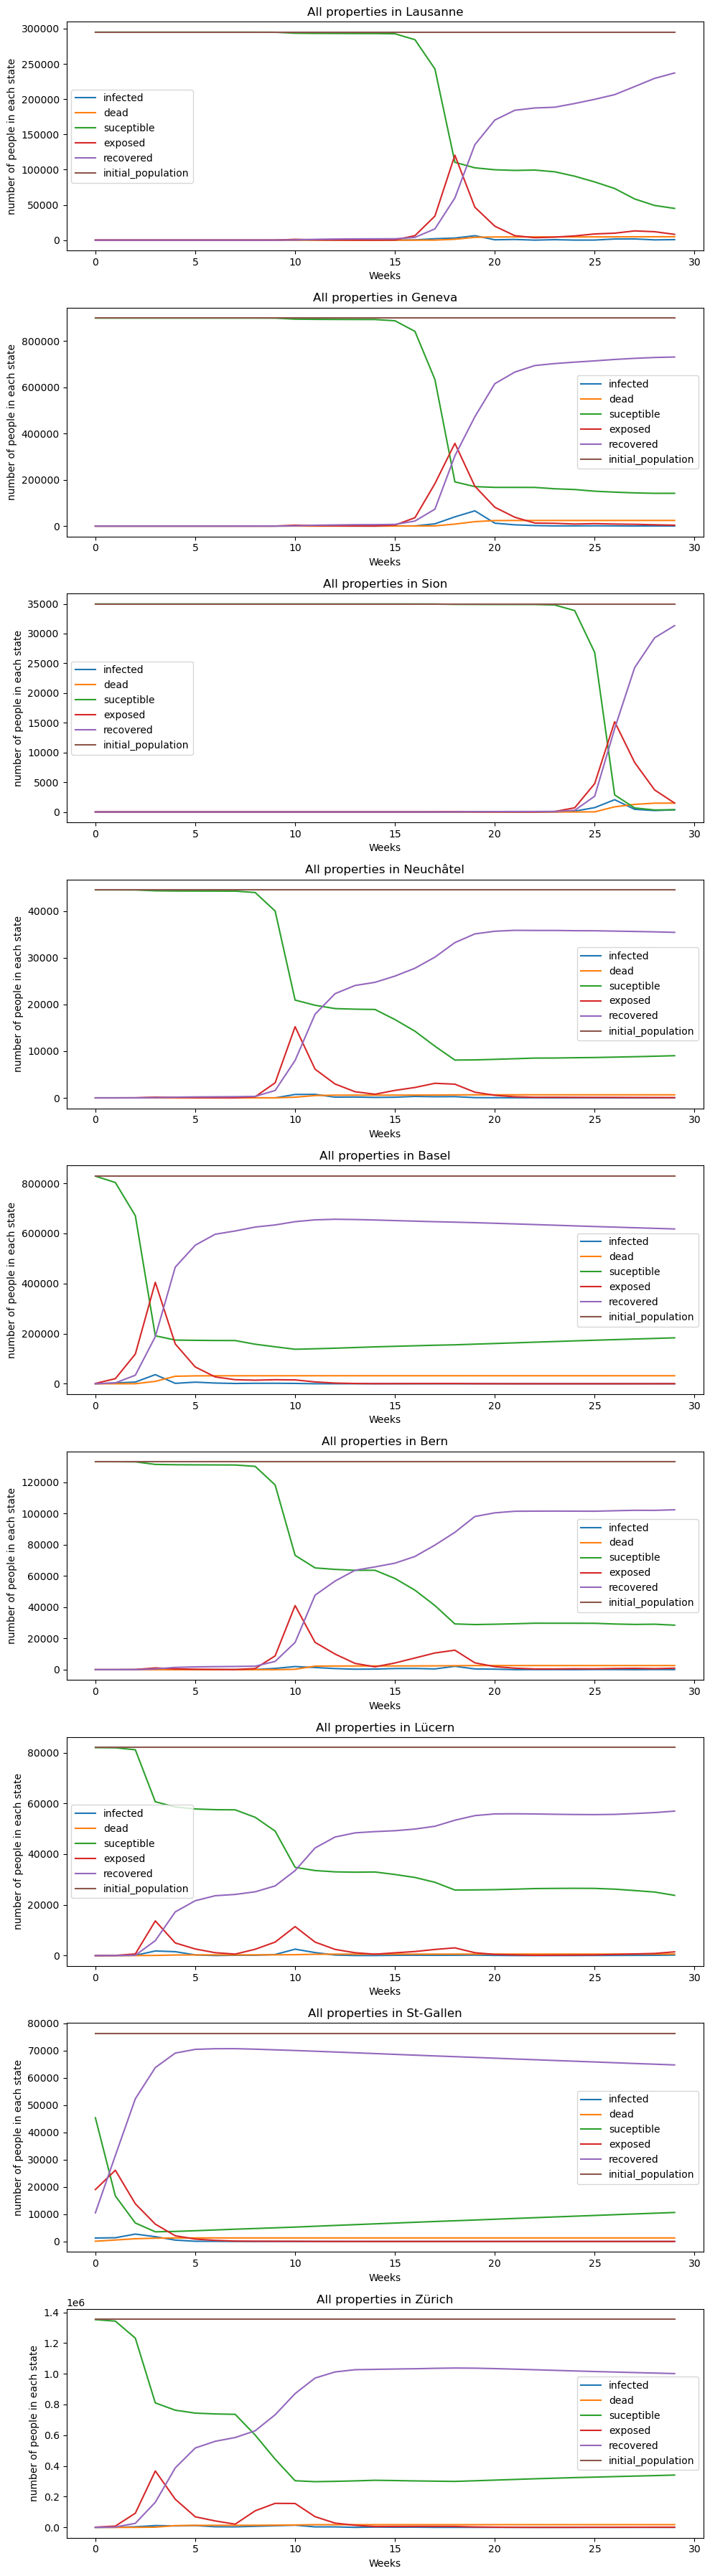

In [33]:
fig, ax = plt.subplots(len(cities), 1, figsize=(10, 4 * len(cities)))

for index, (city, city_total) in enumerate(cities.items()):
    [ax[index].plot(y) for y in city_total.values()]
    ax[index].legend(city_total.keys())
    ax[index].set_title(f"All properties in {city}")
    ax[index].set_ylabel('number of people in each state')
    ax[index].set_xlabel('Weeks')

fig.tight_layout()

Text(0.5, 0, 'Weeks')

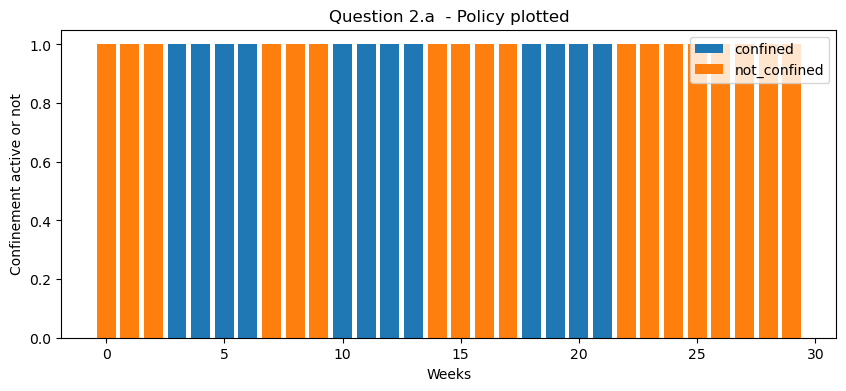

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

weeks = np.arange(len(policy))

total_tmp = {'confined': policy, "not_confined": np.logical_not(policy)}
[ax.bar(weeks, y) for y in total_tmp.values()]
ax.legend(total_tmp.keys())
ax.set_title("Question 2.a  - Policy plotted")
ax.set_ylabel('Confinement active or not')
ax.set_xlabel('Weeks')

# Question 2.b

# Question 2.a

In [35]:
def simulate_russo_policy(n=5, seeds=[0]):
    # For each episode save the total days confined and total dead
    tot_days_confined = []
    tot_dead = []
    cum_rewards = []
    for i in range(n):
        tot, cit, act, pol, r = exec_russo_policy(env, n_weeks=30, simulation_seed=seeds[i])
        cum_rewards.append(torch.sum(torch.tensor(r)))
        tot_dead.append(tot['dead'][-1])
        tot_days_confined.append(7 * np.sum(pol))
    return tot_days_confined, tot_dead, cum_rewards

In [36]:
total_days_confined, total_dead, cumulative_rewards = simulate_russo_policy(n=50, seeds=np.arange(50))

In [37]:
# Print the mean and std
print(f"Mean total days confined: {np.mean(total_days_confined)}")
print(f"Std total days confined: {np.std(total_days_confined)}")
print(f"Mean total dead: {np.mean(total_dead)}")
print(f"Std total dead: {np.std(total_dead)}")
print(f"Mean cumulative rewards: {np.mean(cumulative_rewards)}")
print(f"Std cumulative rewards: {np.std(cumulative_rewards)}")

Mean total days confined: 99.96
Std total days confined: 17.091471557475675
Mean total dead: 58922.9
Std total dead: 19502.99590037387
Mean cumulative rewards: -70.28966522216797
Std cumulative rewards: 58.938175201416016


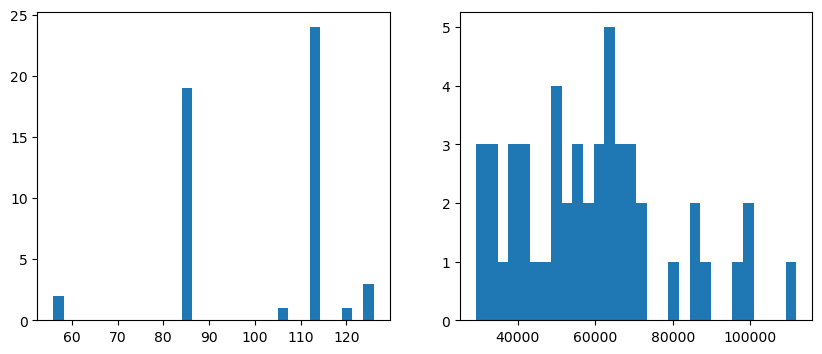

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(total_days_confined, bins=30, label='total_confined')
ax[1].hist(total_dead, bins=30, label='total_dead')
plt.show()

In [38]:
# TODO:
# 1. Clean up the code
# 2. Add comments
# 3. Figure out notebook naming and memory issues
# 4. Improve the policy plotting
# 5. Add histograms

# 6. Rewrite